## Setup

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os

### Enforce determinism
# For CUDA >= 10.2
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
# torch.use_deterministic_algorithms(True)
# torch.manual_seed(0)

import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 2

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Device: cuda:2


In [2]:
from pathlib import Path
import sys
import os

def get_base_folder(project_root = "tim-taras-sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_project_folder(base_folder=None, project_folder_name='sfc-errors'):
	if base_folder is None:
		base_folder = get_base_folder()
	
	return Path(base_folder) / project_folder_name

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

In [3]:
base_path = get_base_folder()
print(f"Base path: {base_path}")

project_path = get_project_folder(base_folder=base_path)
print(f"Project path: {project_path}")

sys.path.append(base_path)
sys.path.append(str(project_path))

Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors
Project path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors


In [4]:
datapath = get_data_path(base_path) 
datapath

PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data')

In [5]:
# Additionally, setup the logging file so that we can track the output even when disconnected from the front-end Jupyter interface
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


## Loading the model

We'll work with Gemma-2 2B (base version)

In [13]:
from sae_lens import HookedSAETransformer

USE_INSTRUCT = False
PARAMS_COUNT = 2

MODEL_NAME = f'gemma-2-{PARAMS_COUNT}b' + ('-it' if USE_INSTRUCT else '')
print(f'Using {MODEL_NAME}')

model = HookedSAETransformer.from_pretrained(MODEL_NAME, device=device, dtype=torch.bfloat16)
model

Using gemma-2-2b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


HookedSAETransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-25): 26 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
      

## Loading the data

This uses my custom dataloader class, which parses raw data and prepares into a nice format for SFC, including providing some useful metadata such as token positions for where the answer should be, attention masks etc. The details of the class are convoluted because it was developed for a more general purpose than verb agreement tasks, so you can largely ignore the next few cells.

In [14]:
from classes.sfc_data_loader import SFCDatasetLoader
import utils.prompts as prompts
from utils.enums import *

In [15]:
DATASET_NAME = SupportedDatasets.VERB_AGREEMENT_TEST

dataloader = SFCDatasetLoader(DATASET_NAME, model,
                              local_dataset=True, base_folder_path=datapath)

In [16]:
clean_dataset, corrupted_dataset = dataloader.get_clean_corrupted_datasets(tokenize=True, apply_chat_template=False, 
                                                                           prepend_generation_prefix=True,
                                                                           use_most_common_length=True, 
                                                                           save_filtered_dataset=True)

Dataset SupportedDatasets.VERB_AGREEMENT_TEST has constant length prompts. Skipping padding calculation.


100%|██████████| 25269/25269 [00:32<00:00, 773.20it/s]


Corrupted dataset here refers to the collection of patched prompts and their answers (verb completions) in the SFC paper terminology.

In [17]:
CONTROL_SEQ_LEN = clean_dataset['control_sequence_length'][0].item() # how many first tokens to ignore when computing SFC scores
N_CONTEXT = clean_dataset['prompt'].shape[1]

CONTROL_SEQ_LEN, N_CONTEXT

(2, 7)

In [18]:
print('Clean dataset:')
for prompt in clean_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')

  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

print('Corrupted dataset:')
for prompt in corrupted_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')
  
  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

Clean dataset:

Prompt: <bos>The doctors that the assistant follows

(-2, <bos>) (-1, The) (0,  doctors) (1,  that) (2,  the) (3,  assistant) (4,  follows) 

Prompt: <bos>The victim that the executive follows

(-2, <bos>) (-1, The) (0,  victim) (1,  that) (2,  the) (3,  executive) (4,  follows) 

Prompt: <bos>The poets that the parents hate

(-2, <bos>) (-1, The) (0,  poets) (1,  that) (2,  the) (3,  parents) (4,  hate) 
Corrupted dataset:

Prompt: <bos>The doctor that the assistant follows

(-2, <bos>) (-1, The) (0,  doctor) (1,  that) (2,  the) (3,  assistant) (4,  follows) 

Prompt: <bos>The victims that the executive follows

(-2, <bos>) (-1, The) (0,  victims) (1,  that) (2,  the) (3,  executive) (4,  follows) 

Prompt: <bos>The poet that the parents hate

(-2, <bos>) (-1, The) (0,  poet) (1,  that) (2,  the) (3,  parents) (4,  hate) 


In [155]:
model.to_string(0)

'<pad>'

In [19]:
# Sanity checks

# Control sequence length must be the same for all samples in both datasets
clean_ds_control_len = clean_dataset['control_sequence_length']
corrupted_ds_control_len = corrupted_dataset['control_sequence_length']

assert torch.all(corrupted_ds_control_len == corrupted_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert torch.all(clean_ds_control_len == clean_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert clean_ds_control_len[0] == corrupted_ds_control_len[0], "Control sequence length is not the same for clean and corrupted samples in the dataset"
assert clean_dataset['answer'].max().item() < model.cfg.d_vocab, "Clean answers exceed vocab size"
assert corrupted_dataset['answer'].max().item() < model.cfg.d_vocab, "Patched answers exceed vocab size"
assert (clean_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"
assert (corrupted_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"

# Setting up the SAEs

In [20]:
from classes.sfc_model import SFC_Gemma

RUN_WITH_SAES = True # we'll need to run the model with attached SAEs

# Determine the caching device, where we'll load our SAEs and compute the SFC scores
if RUN_WITH_SAES:
    caching_device = device 
else:
    caching_device = "cuda:3"


caching_device

'cuda:2'

For replicating the SFC part from the paper I used my custom SFC_Gemma class. In short, it
- Loads a Gemma model and its Gemma Scope SAEs (either attaching them to the model or not)
- Provides interface methods to compute SFC scores (currently, only attr patching is supported) on an arbitrary dataset (that follows the format of my SFCDatasetLoader class from above)

In [21]:
EXPERIMENT = 'sva_rc_test'

clear_cache()
sfc_model = SFC_Gemma(model, params_count=PARAMS_COUNT, control_seq_len=CONTROL_SEQ_LEN, 
                      attach_saes=RUN_WITH_SAES, caching_device=caching_device,
                      data_dir=datapath, experiment_name=EXPERIMENT)
clear_cache()

# sfc_model.print_saes()
# sfc_model.model.cfg
# , sfc_model.saes[0].cfg.dtype

Using 16K SAEs for the first 26 layers, the rest 0 layer(s) - 131k SAEs
Loaded SFC scores from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_test/sfc_scores.pkl
Loaded mean activations from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_test/mean_activations.pkl


# Main part

Here we'll call use CircuitEvaluator class, which encapsulates the SFC circuit evaluation logic.

In [170]:
from classes.sfc_evaluator import CircuitEvaluator
circuit_evaluator = CircuitEvaluator(sfc_model)

In [171]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

In [173]:
# IMPORTANT - this should match the batch size used to compute the scores that are loaded below
batch_size = 1024

## Loading the faithfulness scores

In [174]:
from typing import List, Dict, Any, Tuple

def load_full_experiment_results(
    data_dir: str,
    experiment_name: str,
    filename: str = "full_experiment_results.pt"
) -> Tuple[List, Dict, torch.Tensor, torch.Tensor]:
    """
    Loads and unpacks all key data structures from a saved experiment results file.

    Args:
        data_dir: The base data directory path.
        experiment_name: The name of the specific experiment sub-folder.
        filename: The name of the file to load.

    Returns:
        A tuple containing the four data structures:
        (faithfulness_scores, circuit_metrics, full_model_metrics, empty_circuit_metrics)
        Returns (None, None, None, None) if the file is not found.
    """
    filepath = Path(data_dir) / experiment_name / filename
    
    if not filepath.exists():
        print(f"Error: File not found at {filepath}")
        return None, None, None, None
        
    print(f"Loading full experiment results from: {filepath}")
    results_bundle = torch.load(filepath, weights_only=False)
    print("Load complete. Unpacking results...")
    
    # Unpack the dictionary into the original data structures
    faithfulness_scores = results_bundle.get('faithfulness_scores_by_threshold')
    circuit_metrics = results_bundle.get('circuit_metrics_by_threshold')
    full_model_metrics = results_bundle.get('full_model_metrics')
    empty_circuit_metrics = results_bundle.get('empty_circuit_metrics')
    
    return faithfulness_scores, circuit_metrics, full_model_metrics, empty_circuit_metrics

In [225]:
FNAME = 'faith_filtered_mm_4_mc_2.pt' # 'faith_filtered_mm_4.pt' # 'faith_all_thresholds.pt'
EXPERIMENT = 'sva_rc_filtered' # sva_rc_filtered, sva_rc_test

# --- 1. Load all results from the file ---
(faithfulness_scores_by_threshold, 
 original_circuit_metrics_by_threshold, 
 original_full_model_metrics, 
 original_full_empty_metrics) = load_full_experiment_results(
    data_dir=datapath, 
    experiment_name=EXPERIMENT,
    filename=FNAME
)

# --- 2. Verify the loaded data and proceed with analysis ---
if faithfulness_scores_by_threshold is not None:
    print("\n--- Data successfully loaded ---")
    print(f"Number of thresholds evaluated: {len(faithfulness_scores_by_threshold)}")
    
    # You can now access all the data structures needed for your verification script
    print(f"Shape of full model metrics (m(M)): {original_full_model_metrics.shape}")
    print(f"Shape of empty circuit metrics (m(∅)): {original_full_empty_metrics.shape}")
    
    # Example: Get the circuit metrics for the first threshold
    first_threshold = faithfulness_scores_by_threshold[0]['threshold']
    first_circuit_metrics = original_circuit_metrics_by_threshold[first_threshold]
    print(f"Shape of circuit metrics (m(C)) for threshold {first_threshold:.6f}: {first_circuit_metrics.shape}")

Loading full experiment results from: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_filtered/faith_filtered_mm_4_mc_2.pt
Load complete. Unpacking results...

--- Data successfully loaded ---
Number of thresholds evaluated: 1
Shape of full model metrics (m(M)): torch.Size([10431])
Shape of empty circuit metrics (m(∅)): torch.Size([10431])
Shape of circuit metrics (m(C)) for threshold 0.000037: torch.Size([10431])


## Plot Histograms of Faithfulness Scores for Each Threshold


--- Plotting Full-Range Faithfulness Score Distributions (Stats in Title) ---


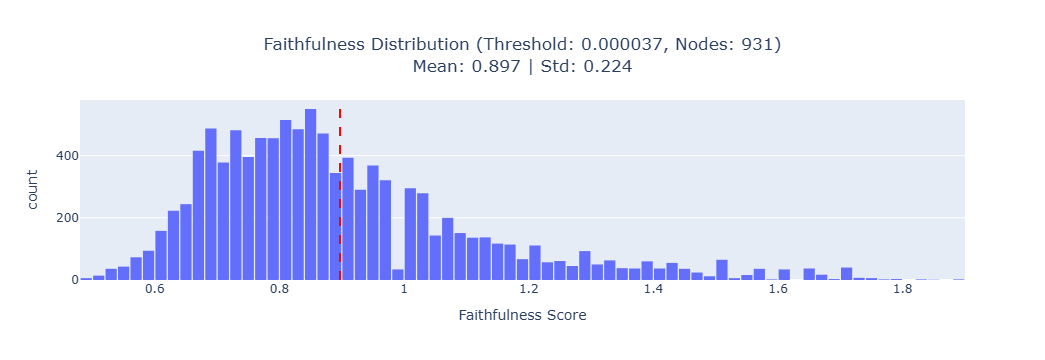

In [227]:
# In a new cell after the evaluation loop

import plotly.express as px
import numpy as np

print("\n--- Plotting Full-Range Faithfulness Score Distributions (Stats in Title) ---")

# This loop iterates through the results we stored earlier
for result in faithfulness_scores_by_threshold:
    threshold = result['threshold']
    n_nodes = result['n_nodes']
    scores_tensor = result['scores']
    
    # Filter out only non-finite values for calculations
    finite_scores_mask = torch.isfinite(scores_tensor)
    scores = scores_tensor[finite_scores_mask].float().numpy()
    
    # Calculate statistics on the finite scores
    mean_val = np.mean(scores)
    std_val = np.std(scores)
    
    # --- MODIFICATION: Create a dynamic title with the stats ---
    title_text = (f"Faithfulness Distribution (Threshold: {threshold:.6f}, Nodes: {n_nodes})<br>"
                  f"Mean: {mean_val:.3f} | Std: {std_val:.3f}")

    fig = px.histogram(
        x=scores,
        nbins=100,
        title=title_text, # Use the new dynamic title
        labels={'x': 'Faithfulness Score'}
    )
    
    # Add a vertical line at the mean for visual reference
    fig.add_vline(
        x=mean_val, 
        line_width=2, 
        line_dash="dash", 
        line_color="red"
        # The annotation for the line itself is removed for a cleaner look
    )
    
    # --- MODIFICATION: Update layout without the annotation box ---
    fig.update_layout(
        title_x=0.5,
        bargap=0.1
    )
    
    fig.show()

## Outlier scores analysis

Created DataFrame with 10431 data points for plotting.


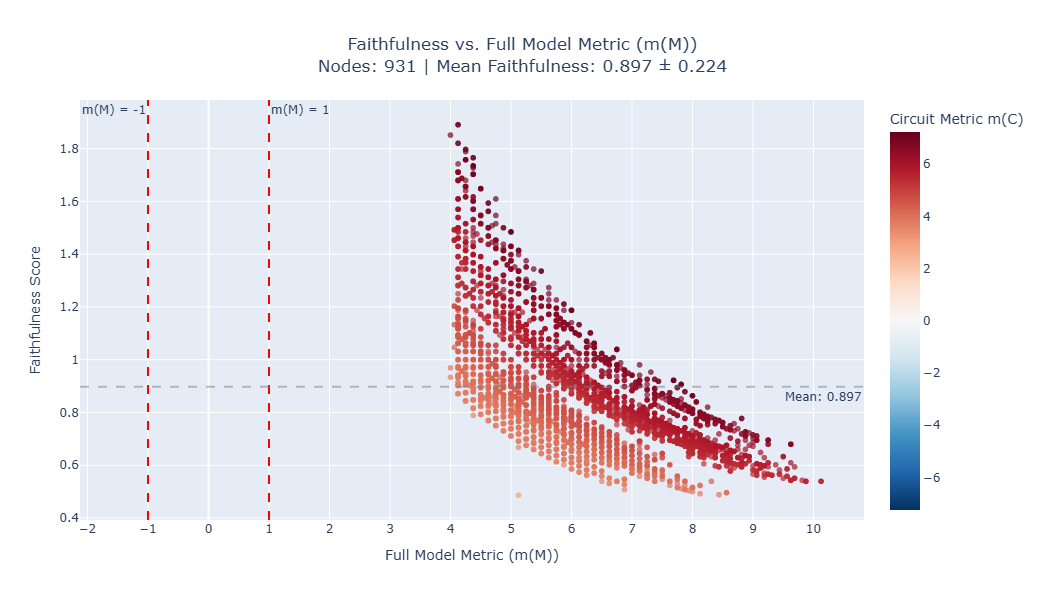

In [229]:
import plotly.express as px
import torch
import numpy as np
import pandas as pd
from IPython.display import display

# This code assumes these variables are already loaded in your environment:
# - faithfulness_scores_by_threshold
# - original_circuit_metrics_by_threshold
# - original_full_model_metrics
# - original_full_empty_metrics

# --- 1. Select Data for a Single Threshold ---

threshold_index_to_analyze = 0
selected_threshold_data = faithfulness_scores_by_threshold[threshold_index_to_analyze]
selected_faithfulness_scores = selected_threshold_data['scores']
selected_circuit_metrics = original_circuit_metrics_by_threshold[selected_threshold_data['threshold']]

# --- MODIFICATION: Get n_nodes from the data ---
n_nodes = selected_threshold_data['n_nodes']

# --- 2. Assemble Data into a Pandas DataFrame ---

finite_mask = torch.isfinite(selected_faithfulness_scores)
plot_data_dict = {
    'faithfulness_score': selected_faithfulness_scores[finite_mask].float().cpu().numpy(),
    'full_model_metric': original_full_model_metrics[finite_mask].float().cpu().numpy(),
    'circuit_metric': selected_circuit_metrics[finite_mask].float().cpu().numpy(),
    'empty_metric': original_full_empty_metrics[finite_mask].float().cpu().numpy(),
    'original_index': np.where(finite_mask.cpu().numpy())[0]
}
df = pd.DataFrame(plot_data_dict)
print(f"Created DataFrame with {len(df)} data points for plotting.")

# --- MODIFICATION: Calculate statistics for the title ---
mean_faithfulness = df['faithfulness_score'].mean()
std_faithfulness = df['faithfulness_score'].std()

# --- MODIFICATION: Create the new, more informative title ---
new_title_text = (
    f"Faithfulness vs. Full Model Metric (m(M))<br>"
    f"Nodes: {n_nodes:,} | Mean Faithfulness: {mean_faithfulness:.3f} ± {std_faithfulness:.3f}"
)

# --- 3. Create the Interactive Scatter Plot using the DataFrame ---

fig = px.scatter(
    data_frame=df,
    x='full_model_metric',
    y='faithfulness_score',
    color='circuit_metric',
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0,
    title=new_title_text, # <-- Use the new title
    labels={
        "full_model_metric": "Full Model Metric (m(M))",
        "faithfulness_score": "Faithfulness Score",
        "circuit_metric": "Circuit Metric m(C)"
    },
    opacity=0.7,
    custom_data=['original_index', 'full_model_metric', 'empty_metric', 'faithfulness_score', 'circuit_metric']
)

fig.update_traces(
    hovertemplate="<b>Faithfulness: %{customdata[3]:.3f}</b><br><br>" +
                  "m(C): %{customdata[4]:.3f}<br>" +
                  "m(M): %{customdata[1]:.3f}<br>" +
                  "m(∅): %{customdata[2]:.3f}<br>" +
                  "Original Index: %{customdata[0]}"
)

# --- 4. Add Vertical and Horizontal Lines ---

# Vertical lines for m(M)
fig.add_vline(
    x=1, line_width=2, line_dash="dash", line_color="red",
    annotation_text="m(M) = 1", annotation_position="top right"
)
fig.add_vline(
    x=-1, line_width=2, line_dash="dash", line_color="red",
    annotation_text="m(M) = -1", annotation_position="top left"
)

# --- MODIFICATION: Add horizontal line for mean faithfulness ---
fig.add_hline(
    y=mean_faithfulness,
    line_width=2,
    line_dash="dash",
    # Use an RGBA color string: rgba(red, green, blue, alpha)
    # SlateGray (112, 128, 144) with 50% opacity is a good choice.
    line_color="rgba(112, 128, 144, 0.5)",
    annotation_text=f"Mean: {mean_faithfulness:.3f}",
    annotation_position="bottom right"
)

# --- 5. Finalize and Show the Plot ---

fig.update_layout(
    title_x=0.5,
    xaxis=dict(dtick=1),
    height=600,
)

fig.show()

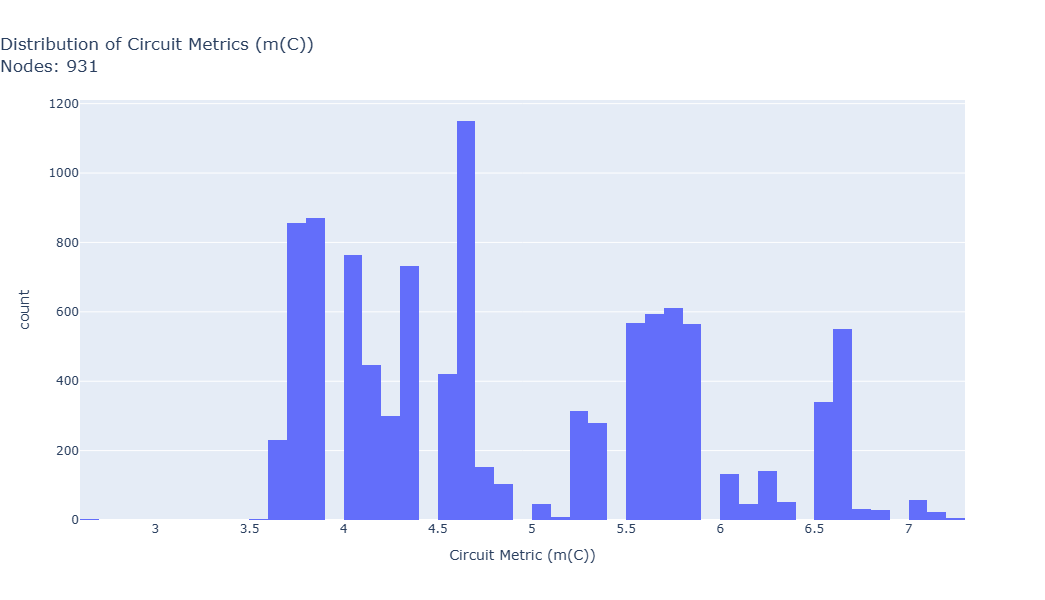

In [233]:
import plotly.express as px

# --- Plot the distribution of Circuit Metrics for the selected threshold ---

# Create a descriptive title
title_text = f"Distribution of Circuit Metrics (m(C))<br>Nodes: {n_nodes:,}"

# Create the histogram using the 'circuit_metric' column from our DataFrame
fig_circuit_hist = px.histogram(
    df,
    x='circuit_metric',
    title=title_text,
    labels={'circuit_metric': 'Circuit Metric (m(C))'},
    nbins=50  # You can adjust the number of bins
)

# Center the title and show the plot
fig_circuit_hist.update_layout(title_x=0., height=600)
fig_circuit_hist.show()

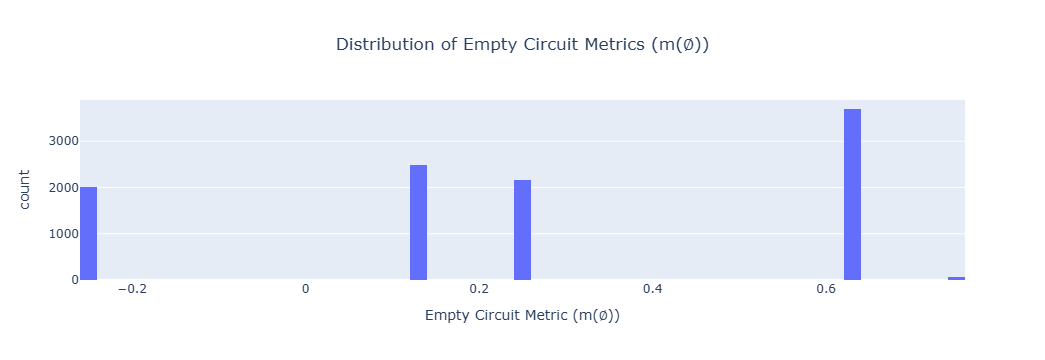

In [234]:
import plotly.express as px

# --- Plot the distribution of Empty Circuit Metrics ---
# Note: This metric is the same regardless of the threshold, but we plot
# it using the filtered data for consistency with the other plots.

# Create a descriptive title
title_text = "Distribution of Empty Circuit Metrics (m(∅))"

# Create the histogram using the 'empty_metric' column from our DataFrame
fig_empty_hist = px.histogram(
    df,
    x='empty_metric',
    title=title_text,
    labels={'empty_metric': 'Empty Circuit Metric (m(∅))'},
    nbins=100 # You can adjust the number of bins
)

# Center the title and show the plot
fig_empty_hist.update_layout(title_x=0.5)
fig_empty_hist.show()

## Filtering outliers

How many samples do we have larger than a given threshold for full model metric m(M)?

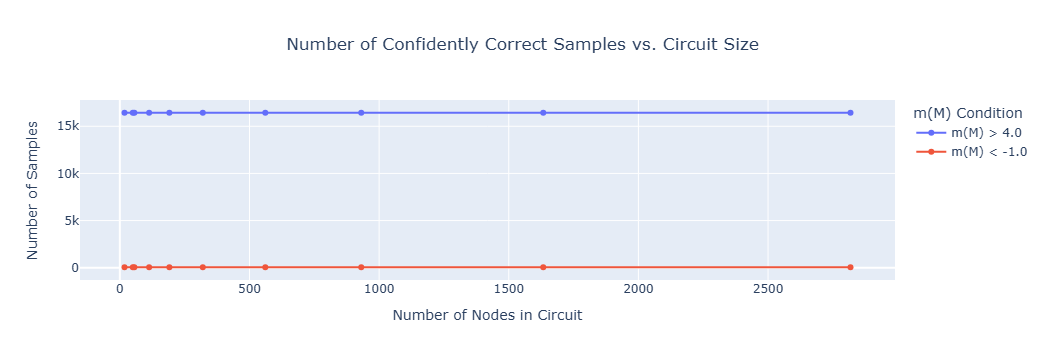

In [217]:
import plotly.express as px
import torch
import pandas as pd

# --- 1. Configuration ---

# Define the cutoffs for what we consider "confidently correct"
MM_CUTOFF_POSITIVE = 4.0
MM_CUTOFF_NEGATIVE = -1.0

# --- 2. Process Data for Each Threshold ---

if 'faithfulness_scores_by_threshold' not in locals():
    print("Error: `faithfulness_scores_by_threshold` not found. Please run the evaluation first.")
else:
    analysis_results = []
    for result in faithfulness_scores_by_threshold:
        # Extract data for the current threshold
        circuit_threshold = result['threshold']
        n_nodes = result['n_nodes']
        faithfulness_scores = result['scores']

        # IMPORTANT: We must filter m(M) using the same finite mask as our other plots
        # to ensure we are counting from the exact same population of samples.
        finite_mask = torch.isfinite(faithfulness_scores)
        filtered_mm_metrics = original_full_model_metrics[finite_mask]

        # Count how many samples in this filtered set exceed the cutoffs
        count_positive = torch.sum(filtered_mm_metrics > MM_CUTOFF_POSITIVE).item()
        count_negative = torch.sum(filtered_mm_metrics < MM_CUTOFF_NEGATIVE).item()

        # Store the results
        analysis_results.append({
            'circuit_threshold': circuit_threshold,
            'n_nodes_in_circuit': n_nodes,
            'count_above_positive_cutoff': count_positive,
            'count_below_negative_cutoff': count_negative,
            'total_finite_samples': len(filtered_mm_metrics)
        })

    # Convert the results to a DataFrame for easy plotting
    df_counts = pd.DataFrame(analysis_results)

    # --- 3. Prepare DataFrame for Plotting (Melting) ---

    # "Melt" the DataFrame to make it "long", which is the ideal format for Plotly Express
    # This lets us plot both counts as separate lines with a single command.
    df_melted = pd.melt(
        df_counts,
        id_vars=['circuit_threshold', 'n_nodes_in_circuit'],
        value_vars=['count_above_positive_cutoff', 'count_below_negative_cutoff'],
        var_name='metric_type',
        value_name='sample_count'
    )

    # Create more readable labels for the plot legend
    legend_labels = {
        'count_above_positive_cutoff': f'm(M) > {MM_CUTOFF_POSITIVE}',
        'count_below_negative_cutoff': f'm(M) < {MM_CUTOFF_NEGATIVE}'
    }
    df_melted['condition'] = df_melted['metric_type'].map(legend_labels)

    # --- 4. Create the Line Plot ---

    fig = px.line(
        df_melted,
        x='n_nodes_in_circuit',
        y='sample_count',
        color='condition',  # This creates a separate line for each condition
        markers=True,       # Add markers to show the discrete threshold points
        title='Number of Confidently Correct Samples vs. Circuit Size',
        labels={
            "n_nodes_in_circuit": "Number of Nodes in Circuit",
            "sample_count": "Number of Samples",
            "condition": "m(M) Condition"
        },
        hover_data={
            "circuit_threshold": ":.6f"
        }
    )

    fig.update_layout(title_x=0.5)
    fig.show()

### Filtering based on full model metric (only) 

Plotting distribution for 16433 samples.
Mean: 0.526 | Std: 0.537


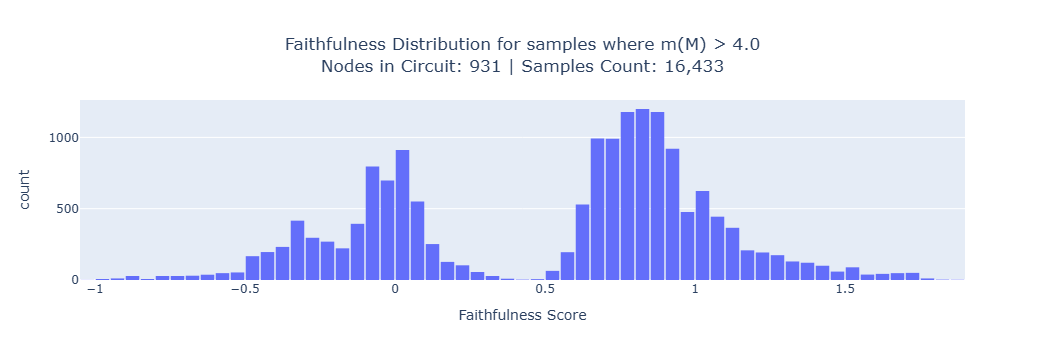

In [218]:
import plotly.express as px
import torch

# --- 1. Configuration ---

# Choose which threshold's faithfulness scores to analyze
threshold_index_to_analyze = 2
# Define the cutoff for the full model metric
MM_CUTOFF_POSITIVE = 4.0

# --- 2. Select and Filter the Data ---

# Get the data for the chosen threshold
result_data = faithfulness_scores_by_threshold[threshold_index_to_analyze]
n_nodes = result_data['n_nodes']  # <-- Get the number of nodes
faithfulness_scores = result_data['scores']

# First, filter out any non-finite values to get a clean baseline
finite_mask = torch.isfinite(faithfulness_scores)
filtered_faithfulness = faithfulness_scores[finite_mask]
filtered_mm_metrics = original_full_model_metrics[finite_mask]

# Now, create the specific condition mask on this clean data
condition_mask = filtered_mm_metrics > MM_CUTOFF_POSITIVE

# Apply the condition mask to get the final set of scores for our histogram
subset_faithfulness_scores = filtered_faithfulness[condition_mask.cpu()]

# --- 3. Plot the Histogram for the Subset ---

# Create a more informative title
num_samples = len(subset_faithfulness_scores)
title_text = f"Faithfulness Distribution for samples where m(M) > {MM_CUTOFF_POSITIVE}<br>Nodes in Circuit: {n_nodes:,} | Samples Count: {num_samples:,}"
print(f"Plotting distribution for {num_samples} samples.")

# Convert to NumPy for plotting
plot_data = subset_faithfulness_scores.float().cpu().numpy()

# Calculate statistics on the finite scores
mean_val = np.mean(plot_data)
std_val = np.std(plot_data)

print(f"Mean: {mean_val:.3f} | Std: {std_val:.3f}")

fig_mm_subset = px.histogram(
    x=plot_data,
    title=title_text,
    labels={'x': 'Faithfulness Score'},
    nbins=100
)

fig_mm_subset.update_layout(title_x=0.5, bargap=0.1)
fig_mm_subset.show()

In [167]:
import torch
import numpy as np

# --- 2. Identify the Evaluation Indices to Save ---
result_data = faithfulness_scores_by_threshold[threshold_index_to_analyze]
faithfulness_scores = result_data['scores']

finite_mask = torch.isfinite(faithfulness_scores)
original_finite_indices = np.where(finite_mask.cpu().numpy())[0]

filtered_mm_metrics = original_full_model_metrics[finite_mask]
condition_mask = filtered_mm_metrics > MM_CUTOFF_POSITIVE

eval_indices_to_save = original_finite_indices[condition_mask.cpu().numpy()]

# --- 3. Create and Save the New Processed Dataset ---
dataloader.save_processed_subset(
    eval_indices=list(eval_indices_to_save),
    batch_size=batch_size,
    clean_dataset=clean_dataset,        # Pass the tokenized clean dataset
    patched_dataset=corrupted_dataset,  # Pass the tokenized patched dataset
    filename_suffix=f"_processed_mm_gt_{str(MM_CUTOFF_POSITIVE).replace('.', 'p')}"
)

Processing 16433 selected evaluation runs to create new dataset...


Processing samples: 100%|██████████| 16433/16433 [00:04<00:00, 3830.71it/s]

Saving new processed dataset with 16433 samples to: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/rc_test_constant_length.json_processed_mm_gt_4p0.json


Creating json from Arrow format:   0%|          | 0/17 [00:00<?, ?ba/s]

Save complete.


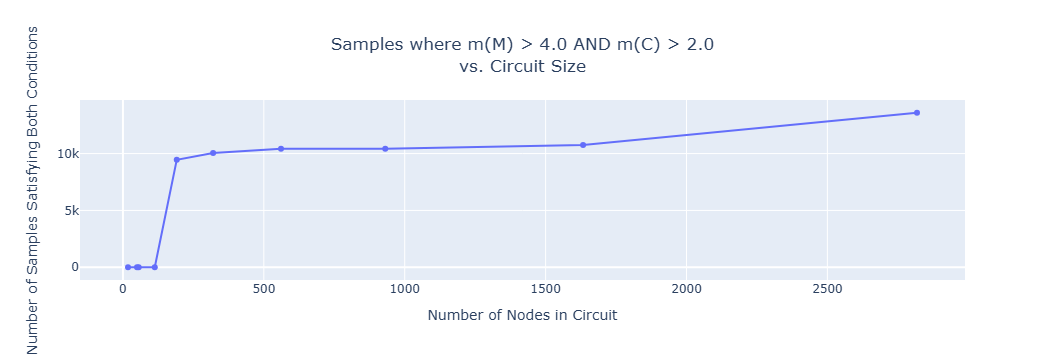

In [219]:
import plotly.express as px
import torch
import pandas as pd

# This code assumes these variables are already loaded in your environment:
# - faithfulness_scores_by_threshold
# - original_circuit_metrics_by_threshold
# - original_full_model_metrics

# --- 1. Configuration ---

# Define the metric thresholds for the joint condition
MM_THRESHOLD = 4.0  # Threshold for the full model metric m(M)
MC_THRESHOLD = 2.0  # Threshold for the circuit metric m(C)

# --- 2. Process Data for Each Threshold ---

if 'faithfulness_scores_by_threshold' not in locals():
    print("Error: Required data not found. Please run the evaluation and loading steps first.")
else:
    analysis_results = []
    for result in faithfulness_scores_by_threshold:
        # Extract data for the current threshold
        circuit_threshold = result['threshold']
        n_nodes = result['n_nodes']
        faithfulness_scores = result['scores']
        
        # Fetch the corresponding circuit metrics tensor
        circuit_metrics = original_circuit_metrics_by_threshold[circuit_threshold]

        # Use the faithfulness scores to create a mask for finite, valid samples
        # This ensures m(M) and m(C) are aligned and come from the same population
        finite_mask = torch.isfinite(faithfulness_scores)

        # Apply the mask to both metric tensors
        filtered_mm_metrics = original_full_model_metrics[finite_mask]
        filtered_mc_metrics = circuit_metrics[finite_mask]

        # --- Create and apply the joint condition ---
        # Condition 1: Full model metric is above its threshold
        mask_mm = filtered_mm_metrics > MM_THRESHOLD
        
        # Condition 2: Circuit metric is above its threshold
        mask_mc = filtered_mc_metrics > MC_THRESHOLD
        
        # Combine the conditions with a logical AND
        joint_mask = mask_mm & mask_mc
        
        # Count how many samples satisfy both conditions
        count = torch.sum(joint_mask).item()
        
        # Store the results
        analysis_results.append({
            'circuit_threshold': circuit_threshold,
            'n_nodes_in_circuit': n_nodes,
            'joint_condition_count': count,
            'total_finite_samples': len(filtered_mm_metrics)
        })

    # Convert the results to a DataFrame for easy plotting
    df_joint_counts = pd.DataFrame(analysis_results)

    # --- 3. Create the Line Plot ---

    title_text = f"Samples where m(M) > {MM_THRESHOLD} AND m(C) > {MC_THRESHOLD}<br>vs. Circuit Size"

    fig = px.line(
        df_joint_counts,
        x='n_nodes_in_circuit',
        y='joint_condition_count',
        markers=True,       # Add markers to show the discrete threshold points
        title=title_text,
        labels={
            "n_nodes_in_circuit": "Number of Nodes in Circuit",
            "joint_condition_count": "Number of Samples Satisfying Both Conditions"
        },
        hover_data={
            "circuit_threshold": ":.6f"
        }
    )

    fig.update_layout(title_x=0.5)
    fig.show()

### Filtering based on full model metric AND circuit metric

In [220]:
import torch
import numpy as np

# --- 1. Configuration ---
# Assumes 'dataloader', 'batch_size', 'clean_dataset', and 'corrupted_dataset' are available.

threshold_index_to_analyze = 2

# --- 2. Identify the Evaluation Indices to Save ---
result_data = faithfulness_scores_by_threshold[threshold_index_to_analyze]
faithfulness_scores = result_data['scores']
circuit_metrics = original_circuit_metrics_by_threshold[result_data['threshold']]

finite_mask = torch.isfinite(faithfulness_scores)
original_finite_indices = np.where(finite_mask.cpu().numpy())[0]

filtered_mm_metrics = original_full_model_metrics[finite_mask]
filtered_mc_metrics = circuit_metrics[finite_mask]

mask_mm = filtered_mm_metrics > MM_THRESHOLD
mask_mc = filtered_mc_metrics > MC_THRESHOLD
joint_mask = mask_mm & mask_mc

eval_indices_to_save = original_finite_indices[joint_mask.cpu().numpy()]

# --- 3. Create and Save the New Processed Dataset ---
dataloader.save_processed_subset(
    eval_indices=list(eval_indices_to_save),
    batch_size=batch_size,
    clean_dataset=clean_dataset,        # Pass the tokenized clean dataset
    patched_dataset=corrupted_dataset,  # Pass the tokenized patched dataset
    filename_suffix=f"_processed_mm_gt_{str(MM_THRESHOLD).replace('.', 'p')}_mc_gt_{str(MC_THRESHOLD).replace('.', 'p')}"
)

Processing 10431 selected evaluation runs to create new dataset...


Processing samples: 100%|██████████| 10431/10431 [00:02<00:00, 3500.09it/s]

Saving new processed dataset with 10431 samples to: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/rc_test_constant_length.json_processed_mm_gt_4p0_mc_gt_2p0.json


Creating json from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Save complete.


Plotting distribution for 10431 samples from Case 2.


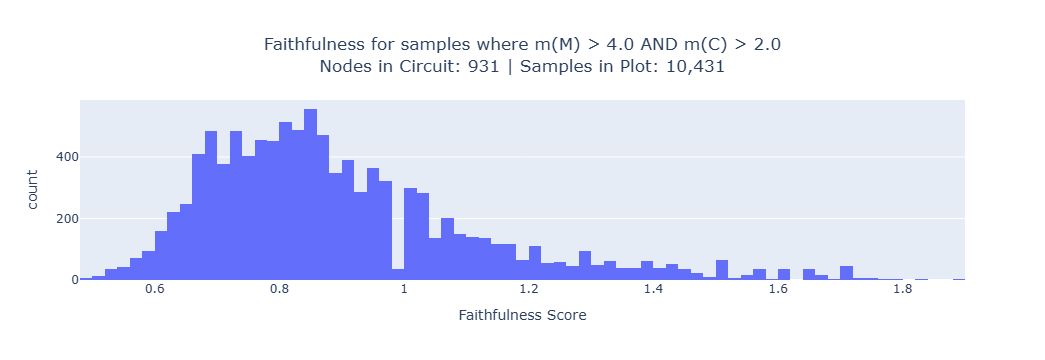

In [224]:
import plotly.express as px
import torch

# --- 1. Configuration ---
# This script assumes the following variables are available from the preceding cells:
# - faithfulness_scores_by_threshold
# - threshold_index_to_analyze
# - MM_THRESHOLD, MC_THRESHOLD
# - The 'eval_indices_to_save' array generated for Case 2.

# --- 2. Select the Subset of Faithfulness Scores ---

# Get the full scores tensor and n_nodes for the chosen threshold
result_data = faithfulness_scores_by_threshold[threshold_index_to_analyze]
full_faithfulness_scores = result_data['scores']
n_nodes = result_data['n_nodes']

# Use the 'eval_indices_to_save' array (now from Case 2) to select the scores.
subset_faithfulness_scores = full_faithfulness_scores[eval_indices_to_save]

# --- 3. Plot the Histogram for the Subset ---

# Create the informative title
num_samples = len(subset_faithfulness_scores)
title_text = f"Faithfulness for samples where m(M) > {MM_THRESHOLD} AND m(C) > {MC_THRESHOLD}<br>Nodes in Circuit: {n_nodes:,} | Samples in Plot: {num_samples:,}"
print(f"Plotting distribution for {num_samples} samples from Case 2.")

# Convert to NumPy for plotting
plot_data = subset_faithfulness_scores.float().cpu().numpy()

fig_joint_subset = px.histogram(
    x=plot_data,
    title=title_text,
    labels={'x': 'Faithfulness Score'},
    nbins=100
)

fig_joint_subset.update_layout(title_x=0.5)
fig_joint_subset.show()

## Sanity check

In [38]:
import pandas as pd
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Any

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
N_OUTLIERS_TO_COLLECT = 3

# ==============================================================================
# 2. HELPER FUNCTIONS
# ==============================================================================

def _get_sample_pair_from_index(
    flat_index: int,
    scores_tensor: torch.Tensor,
    clean_ds: Dict[str, Any],
    patched_ds: Dict[str, Any],
    batch_size: int,
) -> Optional[Tuple[Dict[str, Any], Dict[str, Any]]]:
    """
    Finds the clean-corrupted data pair corresponding to a single outlier index.

    This is the core of the data collection. Given an index from the flat
    faithfulness tensor, it finds the original prompt index and fetches
    the data from *both* the clean and patched datasets at that index.

    It adds rich metadata to each sample, including:
    - `original_dataset_index`: The index within the source dataset (e.g., clean_ds).
    - `outlier_source`: Whether the 'clean' or 'corrupted' prompt's evaluation produced the outlier score.
    - `faithfulness_score`: The score of the outlier.
    - `flat_index`: The index in the full, flat scores tensor for this specific sample (clean or patched).
                     This is crucial for verification.

    Args:
        flat_index: The index in the 1D faithfulness scores tensor that was identified as an outlier.
        scores_tensor: The full 1D scores tensor to retrieve the score from.
        clean_ds: The original clean dataset dictionary.
        patched_ds: The original patched dataset dictionary.
        batch_size: The batch size used during evaluation.

    Returns:
        A tuple containing (clean_sample_dict, corrupted_sample_dict), or None
        if the index is invalid.
    """
    # --- 1. Reverse the mapping from flat index to prompt index ---
    block_size = 2 * batch_size
    batch_num = flat_index // block_size
    pos_in_concat_batch = flat_index % block_size
    index_in_batch = pos_in_concat_batch % batch_size
    original_prompt_index = batch_num * batch_size + index_in_batch

    # Robustness Check: Ensure the calculated index is valid for the datasets.
    if original_prompt_index >= len(clean_ds['prompt']):
        return None

    # --- 2. Calculate the flat indices for BOTH clean and patched prompts in the pair ---
    clean_flat_index = batch_num * block_size + index_in_batch
    patched_flat_index = clean_flat_index + batch_size

    # --- 3. Fetch the data for the pair ---
    clean_sample = {key: clean_ds[key][original_prompt_index] for key in clean_ds.keys()}
    corrupted_sample = {key: patched_ds[key][original_prompt_index] for key in patched_ds.keys()}

    # --- 4. Add rich metadata for context and verification ---
    outlier_score = scores_tensor[flat_index].item()
    is_patched_outlier = pos_in_concat_batch >= batch_size
    
    # Add metadata to the clean sample
    clean_sample['original_dataset_index'] = original_prompt_index
    clean_sample['faithfulness_score'] = outlier_score
    clean_sample['outlier_source'] = "patched" if is_patched_outlier else "clean"
    clean_sample['flat_index'] = clean_flat_index

    # Add metadata to the corrupted sample
    corrupted_sample['original_dataset_index'] = original_prompt_index
    corrupted_sample['faithfulness_score'] = outlier_score
    corrupted_sample['outlier_source'] = "patched" if is_patched_outlier else "clean"
    corrupted_sample['flat_index'] = patched_flat_index
        
    return clean_sample, corrupted_sample

def _collate_samples(samples_list: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Takes a list of individual sample dictionaries and stacks their tensors
    to form a single, unified dataset dictionary.
    """
    # (This function remains unchanged, as it's a general utility)
    if not samples_list: return {}
    keys = samples_list[0].keys(); collated_dataset = {}
    for key in keys:
        all_values = [s[key] for s in samples_list]
        if isinstance(all_values[0], torch.Tensor):
            collated_dataset[key] = torch.stack(all_values)
        else:
            collated_dataset[key] = all_values
    return collated_dataset

# ==============================================================================
# 3. MAIN EXECUTION LOGIC
# ==============================================================================
outlier_datasets_by_threshold = []

print(f"--- Creating paired outlier datasets (Top/Bottom {N_OUTLIERS_TO_COLLECT}) ---")

for result in faithfulness_scores_by_threshold:
    threshold, scores = result['threshold'], result['scores']
    print(f"\nProcessing threshold: {threshold:.6f}...")

    k = min(N_OUTLIERS_TO_COLLECT, len(scores) // 2)
    if k == 0: continue

    _, top_indices = torch.topk(scores, k=k, largest=True)
    _, bottom_indices = torch.topk(scores, k=k, largest=False)

    # Initialize lists to hold the pairs.
    top_clean_samples, top_corrupted_samples = [], []
    bottom_clean_samples, bottom_corrupted_samples = [], []

    # Collect top outlier pairs.
    for idx in top_indices:
        pair = _get_sample_pair_from_index(idx.item(), scores, clean_dataset, corrupted_dataset, batch_size)
        if pair:
            top_clean_samples.append(pair[0])
            top_corrupted_samples.append(pair[1])
            
    # Collect bottom outlier pairs.
    for idx in bottom_indices:
        pair = _get_sample_pair_from_index(idx.item(), scores, clean_dataset, corrupted_dataset, batch_size)
        if pair:
            bottom_clean_samples.append(pair[0])
            bottom_corrupted_samples.append(pair[1])

    # Collate the lists into final dataset dictionaries.
    outlier_datasets_by_threshold.append({
        'threshold': threshold,
        'n_nodes': result['n_nodes'],
        'top_outliers': {
            'clean': _collate_samples(top_clean_samples),
            'corrupted': _collate_samples(top_corrupted_samples)
        },
        'bottom_outliers': {
            'clean': _collate_samples(bottom_clean_samples),
            'corrupted': _collate_samples(bottom_corrupted_samples)
        }
    })
    print(f"  Created 'top outliers' datasets with {len(top_clean_samples)} samples.")
    print(f"  Created 'bottom outliers' datasets with {len(bottom_clean_samples)} samples.")

print("\nProcessing complete. `outlier_datasets_by_threshold` has been rebuilt with paired data.")

--- Creating paired outlier datasets (Top/Bottom 3) ---

Processing threshold: 0.000010...
  Created 'top outliers' datasets with 3 samples.
  Created 'bottom outliers' datasets with 3 samples.

Processing threshold: 0.000019...
  Created 'top outliers' datasets with 3 samples.
  Created 'bottom outliers' datasets with 3 samples.

Processing threshold: 0.000037...
  Created 'top outliers' datasets with 3 samples.
  Created 'bottom outliers' datasets with 3 samples.

Processing threshold: 0.000072...
  Created 'top outliers' datasets with 3 samples.
  Created 'bottom outliers' datasets with 3 samples.

Processing threshold: 0.000139...
  Created 'top outliers' datasets with 3 samples.
  Created 'bottom outliers' datasets with 3 samples.

Processing threshold: 0.000268...
  Created 'top outliers' datasets with 3 samples.
  Created 'bottom outliers' datasets with 3 samples.

Processing threshold: 0.000518...
  Created 'top outliers' datasets with 3 samples.
  Created 'bottom outliers' dat

In [39]:
# ==============================================================================
# 4. VERIFICATION AND USAGE EXAMPLE (for Paired Data)
# ==============================================================================

# --- Configuration ---
# How many examples to display from the top and bottom of the outlier datasets.
N_EXAMPLES_TO_SHOW = 3

# --- Verification Logic ---
if not outlier_datasets_by_threshold:
    print("No outlier datasets were created to verify.")
else:
    # Get the results for the first threshold that was analyzed.
    first_threshold_results = outlier_datasets_by_threshold[threshold_index_to_analyze]

    print(f"\n--- Verification for threshold: {first_threshold_results['threshold']:.6f} ---")
    print(f"Showing the top {N_EXAMPLES_TO_SHOW} most extreme outlier pairs from this set.")

    # --- Display Top Outliers (Highest Faithfulness Scores) ---
    top_outliers = first_threshold_results['top_outliers']
    print("\n\n===========================================")
    print("--- Top Outliers (Highest Faithfulness) ---")
    print("===========================================")
    
    if top_outliers['clean'] and len(top_outliers['clean']['prompt']) > 0:
        num_to_show = min(N_EXAMPLES_TO_SHOW, len(top_outliers['clean']['prompt']))
        
        for i in range(num_to_show):
            # Extract data for the i-th pair
            clean_sample = {key: top_outliers['clean'][key][i] for key in top_outliers['clean']}
            corrupted_sample = {key: top_outliers['corrupted'][key][i] for key in top_outliers['corrupted']}
            
            # They share the same metadata, so we can get it from either
            score = clean_sample['faithfulness_score']
            outlier_source = clean_sample['outlier_source']
            original_index = clean_sample['original_dataset_index']

            # Clean padding tokens for clear display
            clean_prompt_tensor = clean_sample['prompt']
            corrupted_prompt_tensor = corrupted_sample['prompt']
            clean_text = model.to_string(clean_prompt_tensor[clean_prompt_tensor != model.tokenizer.pad_token_id])
            corrupted_text = model.to_string(corrupted_prompt_tensor[corrupted_prompt_tensor != model.tokenizer.pad_token_id])

            ecm_clean = original_full_empty_metrics[clean_sample['flat_index']]
            ecm_patched = original_full_empty_metrics[corrupted_sample['flat_index']]

            full_clean = original_full_model_metrics[clean_sample['flat_index']]
            full_patched = original_full_model_metrics[corrupted_sample['flat_index']]

            print(f"\n--- Outlier Pair #{i+1} ---")
            print(f"Faithfulness Score: {score:.4f}")
            
            print(f'ECM Clean | Patched: {ecm_clean} | {ecm_patched}')
            print(f'FMM Clean | Patched: {full_clean} | {full_patched}')

            print(f"Outlier Source:     The '{outlier_source}' prompt of pair #{original_index}")
            print(f"  -> Clean Prompt:     '{clean_text}'")
            print(f"  -> Corrupted Prompt: '{corrupted_text}'")
            
    else:
        print("No top outliers were collected for this threshold.")

    # --- Display Bottom Outliers (Lowest Faithfulness Scores) ---
    bottom_outliers = first_threshold_results['bottom_outliers']
    print("\n\n============================================")
    print("--- Bottom Outliers (Lowest Faithfulness) ---")
    print("============================================")

    if bottom_outliers['clean'] and len(bottom_outliers['clean']['prompt']) > 0:
        num_to_show = min(N_EXAMPLES_TO_SHOW, len(bottom_outliers['clean']['prompt']))

        for i in range(num_to_show):
            # Extract data for the i-th pair
            clean_sample = {key: bottom_outliers['clean'][key][i] for key in bottom_outliers['clean']}
            corrupted_sample = {key: bottom_outliers['corrupted'][key][i] for key in bottom_outliers['corrupted']}
            
            # Get metadata
            score = clean_sample['faithfulness_score']
            outlier_source = clean_sample['outlier_source']
            original_index = clean_sample['original_dataset_index']

            # Clean padding tokens
            clean_prompt_tensor = clean_sample['prompt']
            corrupted_prompt_tensor = corrupted_sample['prompt']
            clean_text = model.to_string(clean_prompt_tensor[clean_prompt_tensor != model.tokenizer.pad_token_id])
            corrupted_text = model.to_string(corrupted_prompt_tensor[corrupted_prompt_tensor != model.tokenizer.pad_token_id])

            ecm_clean = original_full_empty_metrics[clean_sample['flat_index']]
            ecm_patched = original_full_empty_metrics[corrupted_sample['flat_index']]

            full_clean = original_full_model_metrics[clean_sample['flat_index']]
            full_patched = original_full_model_metrics[corrupted_sample['flat_index']]
            
            print(f"\n--- Outlier Pair #{i+1} ---")
            print(f"Faithfulness Score: {score:.4f}")
            
            print(f'ECM Clean | Patched: {ecm_clean} | {ecm_patched}')
            print(f'FMM Clean | Patched: {full_clean} | {full_patched}')
            
            print(f"Outlier Source:     The '{outlier_source}' prompt of pair #{original_index}")
            print(f"  -> Clean Prompt:     '{clean_text}'")
            print(f"  -> Corrupted Prompt: '{corrupted_text}'")

    else:
        print("No bottom outliers were collected for this threshold.")


--- Verification for threshold: 0.000010 ---
Showing the top 3 most extreme outlier pairs from this set.


--- Top Outliers (Highest Faithfulness) ---

--- Outlier Pair #1 ---
Faithfulness Score: inf
ECM Clean | Patched: -0.125 | 0.125
FMM Clean | Patched: 2.5 | 0.125
Outlier Source:     The 'patched' prompt of pair #1380
  -> Clean Prompt:     '<bos>The fathers that the parents inform'
  -> Corrupted Prompt: '<bos>The father that the parents inform'

--- Outlier Pair #2 ---
Faithfulness Score: inf
ECM Clean | Patched: -0.125 | 0.125
FMM Clean | Patched: 3.625 | 0.125
Outlier Source:     The 'patched' prompt of pair #228
  -> Clean Prompt:     '<bos>The victims that the architects like'
  -> Corrupted Prompt: '<bos>The victim that the architects like'

--- Outlier Pair #3 ---
Faithfulness Score: inf
ECM Clean | Patched: -0.25 | 0.25
FMM Clean | Patched: -0.25 | 6.25
Outlier Source:     The 'clean' prompt of pair #1097
  -> Clean Prompt:     '<bos>The woman that the drivers protect'
  

#### Main test

In [ ]:
# ==============================================================================
# 1. CONFIGURATION FOR VERIFICATION
# ==============================================================================
# Select which threshold from our results we want to verify.
# Defaulting to the first one.
VERIFICATION_THRESHOLD_IDX = 0

# ==============================================================================
# 2. VERIFICATION LOGIC (with enhanced diagnostics)
# ==============================================================================

def _print_metric_comparison(
    title: str,
    original_metric_full: torch.Tensor,
    recalculated_metric: torch.Tensor,
    outlier_data: Dict[str, Dict]
):
    """A helper to print a detailed side-by-side comparison of metric tensors."""
    print(f"\n--- {title} ---")
    print(f"{'#':>3} | {'Outlier Src':>11} | {'Original (Sliced)':>18} | {'Recalculated':>15} | {'Difference':>12}")
    print("-" * 70)
    
    # We need to compare the clean and patched parts separately
    original_clean = original_metric_full[torch.tensor(outlier_data['clean']['flat_index'], dtype=torch.long)]
    original_patched = original_metric_full[torch.tensor(outlier_data['corrupted']['flat_index'], dtype=torch.long)]
    
    recalc_clean, recalc_patched = torch.chunk(recalculated_metric, 2)

    # Print clean prompt comparisons
    for i in range(len(recalc_clean)):
        is_outlier = outlier_data['clean']['outlier_source'][i] == 'clean'
        outlier_marker = ">>" if is_outlier else "  "
        diff = recalc_clean[i] - original_clean[i]
        print(f"{i:<3}{outlier_marker}| {'Clean':>11} | {original_clean[i]:18.4f} | {recalc_clean[i]:15.4f} | {diff:12.4f}")

    # Print patched prompt comparisons
    for i in range(len(recalc_patched)):
        is_outlier = outlier_data['corrupted']['outlier_source'][i] == 'patched'
        outlier_marker = ">>" if is_outlier else "  "
        diff = recalc_patched[i] - original_patched[i]
        print(f"{i:<3}{outlier_marker}| {'corrupted':>11} | {original_patched[i]:18.4f} | {recalc_patched[i]:15.4f} | {diff:12.4f}")

# The main verification function, now with diagnostic calls
def _verify_outlier_set(
    outlier_set_name: str,
    outlier_data: Dict[str, Dict],
    node_threshold: float,
    circuit_evaluator: "CircuitEvaluator",
    # Assuming these are available from the notebook's global scope
    full_empty_metrics: torch.Tensor = original_full_empty_metrics,
    full_model_metrics: torch.Tensor = original_full_model_metrics,
    full_circuit_metrics: torch.Tensor = None, # Will be captured per-threshold
):
    """
    Runs the faithfulness evaluation on a specific outlier dataset and
    compares the result to the originally recorded scores, with detailed diagnostics.
    """
    print(f"\n--- Verifying '{outlier_set_name}' ---")
    
    clean_outliers_dataset = outlier_data['clean']
    if not clean_outliers_dataset:
        print("✅ SKIPPED: No outliers in this set.")
        return

    # 1. Recalculate all three components on the outlier subset
    _, _, circuit_metrics_recalc, full_model_metrics_recalc, empty_metrics_recalc = circuit_evaluator.evaluate_circuit_faithfulness(
        clean_dataset=clean_outliers_dataset,
        patched_dataset=outlier_data['corrupted'],
        node_threshold=node_threshold,
        return_all_metrics=True,
        batch_size=len(clean_outliers_dataset['prompt']),
        verbose=False,
        _return_components_for_verification=True,
    )

    # 2. Print detailed comparisons for each metric component
    _print_metric_comparison("Full Model Metric (m(M)) Comparison", full_model_metrics, full_model_metrics_recalc, outlier_data)
    _print_metric_comparison("Empty Circuit Metric (m(∅)) Comparison", full_empty_metrics, empty_metrics_recalc, outlier_data)
    
    # For circuit metrics, we need the original ones for the specific threshold
    if full_circuit_metrics is not None:
        _print_metric_comparison("Circuit Metric (m(C)) Comparison", full_circuit_metrics, circuit_metrics_recalc, outlier_data)
    else:
        print("\n--- Circuit Metric (m(C)) ---")
        print("Original circuit metrics not provided for comparison.")
        print("Recalculated values:", circuit_metrics_recalc)
    
    # 3. Manually reconstruct the faithfulness score using the three ORIGINAL components
    # This is the "true" original score we want to verify against.
    indices = torch.tensor(outlier_data['clean']['flat_index'] + outlier_data['corrupted']['flat_index'], dtype=torch.long)
    
    original_circuit_sliced = full_circuit_metrics[indices]
    original_full_sliced = full_model_metrics[indices]
    original_empty_sliced = full_empty_metrics[indices]
    
    original_reconstructed_faithfulness = (original_circuit_sliced - original_empty_sliced) / (original_full_sliced - original_empty_sliced)
    original_reconstructed_clean, original_reconstructed_patched = torch.chunk(original_reconstructed_faithfulness, 2)
    
    # 4. Manually reconstruct the faithfulness score using the RECALCULATED components
    recalculated_faithfulness = (circuit_metrics_recalc - original_empty_sliced) / (original_full_sliced - original_empty_sliced)
    
    # Reconstruct the single outlier score list from the recalculated clean/patched pairs
    recalc_clean_scores, recalc_patched_scores = torch.chunk(recalculated_faithfulness, 2)
    
    reconstructed_scores = []
    original_reconstructed = []
    
    for i, outlier_source in enumerate(clean_outliers_dataset['outlier_source']):
        if outlier_source == 'clean':
            reconstructed_scores.append(recalc_clean_scores[i].item())
            original_reconstructed.append(original_reconstructed_clean[i].item())
        else:
            reconstructed_scores.append(recalc_patched_scores[i].item())
            original_reconstructed.append(original_reconstructed_patched[i].item())

    print("\n--- Final Score Comparison ---")
    print("Original Faithfulness Scores (from metadata):", torch.tensor(clean_outliers_dataset['faithfulness_score']))
    print("Original Faithfulness Scores (reconstructed):", torch.tensor(original_reconstructed))
    print("Final Recalculated Scores (reconstructed): ", torch.tensor(reconstructed_scores))

# --- Main Execution ---
if not outlier_datasets_by_threshold:
    print("No outlier datasets available to verify.")
elif VERIFICATION_THRESHOLD_IDX >= len(outlier_datasets_by_threshold):
    print(f"Error: VERIFICATION_THRESHOLD_IDX ({VERIFICATION_THRESHOLD_IDX}) is out of bounds.")
else:
    # Select the specific result set to verify.
    result_to_verify = outlier_datasets_by_threshold[VERIFICATION_THRESHOLD_IDX]
    selected_threshold = result_to_verify['threshold']
    
    # Retrieve the specific circuit metrics for this threshold
    selected_circuit_metrics = original_circuit_metrics_by_threshold[selected_threshold]

    print(f"--- Running Verification for Threshold: {selected_threshold:.6f} ---")
    
    # Verify the 'top outliers' dataset.
    _verify_outlier_set(
        "Top Outliers (High Faithfulness)",
        result_to_verify['top_outliers'],
        selected_threshold,
        circuit_evaluator,
        full_circuit_metrics=selected_circuit_metrics
    )

    # Verify the 'bottom outliers' dataset.
    _verify_outlier_set(
        "Bottom Outliers (Low Faithfulness)",
        result_to_verify['bottom_outliers'],
        selected_threshold,
        circuit_evaluator,
        full_circuit_metrics=selected_circuit_metrics
    )